# ML Pipeline Predicting Backorders 


--- 

## Data

Details of the dataset are located here:

Dataset: https://www.kaggle.com/tiredgeek/predict-bo-trial

## Exploration, Training, and Validation

As part of the project I will examine the _training_ dataset and perform 
 * **data preparation and exploratory data analysis**, 
 * **anomaly detection / removal**,
 * **dimensionality reduction** and then
 * **train and validate 3 different models**.

## Testing

Once the best model is chosen, I will re-train it using the training data.


##  Overview / Roadmap

**General steps**:

* Dataset carpentry & Exploratory Data Analysis
* Create 3 pipelines, each does:
* Train chosen model full training data
* Evaluate model against testing
* Summary / Final thoughts 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import itertools
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

## Load dataset

**Description**
~~~
sku - Random ID for the product
national_inv - Current inventory level for the part
lead_time - Transit time for product (if available)
in_transit_qty - Amount of product in transit from source
forecast_3_month - Forecast sales for the next 3 months
forecast_6_month - Forecast sales for the next 6 months
forecast_9_month - Forecast sales for the next 9 months
sales_1_month - Sales quantity for the prior 1 month time period
sales_3_month - Sales quantity for the prior 3 month time period
sales_6_month - Sales quantity for the prior 6 month time period
sales_9_month - Sales quantity for the prior 9 month time period
min_bank - Minimum recommend amount to stock
potential_issue - Source issue for part identified
pieces_past_due - Parts overdue from source
perf_6_month_avg - Source performance for prior 6 month period
perf_12_month_avg - Source performance for prior 12 month period
local_bo_qty - Amount of stock orders overdue
deck_risk - Part risk flag
oe_constraint - Part risk flag
ppap_risk - Part risk flag
stop_auto_buy - Part risk flag
rev_stop - Part risk flag
went_on_backorder - Product actually went on backorder. **This is the target value.**
~~~

**Note**: This is a real-world dataset without any processing.  

There will also be warnings due to fact that the 1st column is mixing integer and string values.  I'm going to suppress these for better readability.  
The last column is what I am trying to predict.

In [2]:
# Dataset location
DATASET = '/dsa/data/all_datasets/back_order/Kaggle_Training_Dataset_v2.csv'
assert os.path.exists(DATASET)

# Load and shuffle
dataset = pd.read_csv(DATASET).sample(frac = 1).reset_index(drop=True)
dataset.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


## Processing

In this section, goal is to figure out:

* which columns we can use directly,  
* which columns are usable after some processing,  
* and which columns are not processable or obviously irrelevant (like product id) that we will discard.

Then process and prepare this dataset for creating a predictive model.

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
sku                  1687861 non-null object
national_inv         1687860 non-null float64
lead_time            1586967 non-null float64
in_transit_qty       1687860 non-null float64
forecast_3_month     1687860 non-null float64
forecast_6_month     1687860 non-null float64
forecast_9_month     1687860 non-null float64
sales_1_month        1687860 non-null float64
sales_3_month        1687860 non-null float64
sales_6_month        1687860 non-null float64
sales_9_month        1687860 non-null float64
min_bank             1687860 non-null float64
potential_issue      1687860 non-null object
pieces_past_due      1687860 non-null float64
perf_6_month_avg     1687860 non-null float64
perf_12_month_avg    1687860 non-null float64
local_bo_qty         1687860 non-null float64
deck_risk            1687860 non-null object
oe_constraint        1687860 non-null object
ppap_risk        

### Take samples and examine the dataset

In [4]:
dataset.iloc[:3,:6]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month
0,2013153,3.0,12.0,0.0,0.0,0.0
1,3097134,16.0,9.0,0.0,0.0,0.0
2,2940036,4.0,12.0,0.0,0.0,0.0


In [5]:
dataset.iloc[:3,6:12]

,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
dataset.iloc[:3,12:18]

,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk
0,No,0.0,0.63,0.72,0.0,No
1,No,0.0,0.85,0.82,0.0,No
2,No,0.0,0.77,0.73,0.0,No


In [7]:
dataset.iloc[:3,18:24]

,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,No,No,Yes,No,No
1,No,No,Yes,No,No
2,No,No,Yes,No,No


### count the number on Nans in our data

In [8]:
print(dataset.isnull().sum())
print(len(dataset))
print(100894/1687861) # view percent of Nans in the lead time column

sku                       0
national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
went_on_backorder         1
dtype: int64
1687861
0.05977624934754698


### Drop columns that are obviously irrelevant or not processable

In [9]:
dataset = dataset.drop('sku', 1)
#dataset = dataset.drop('lead_time', 1)

### Find unique values of string columns

Now try to make sure that these Yes/No columns really only contains Yes or No.  
If that's true, proceed to convert them into binaries (0s and 1s).

In [10]:
dataset.went_on_backorder.unique() # notice the Nans 

array(['No', 'Yes', nan], dtype=object)

In [11]:
# All the column names of these yes/no columns
yes_no_columns = list(filter(lambda i: dataset[i].dtype!=np.float64, dataset.columns))
print(yes_no_columns)

# look at other columns 
print('potential_issue', dataset['potential_issue'].unique())
print('deck_risk', dataset['deck_risk'].unique())
print('oe_constraint', dataset['oe_constraint'].unique())
print('ppap_risk', dataset['ppap_risk'].unique())
print('stop_auto_buy', dataset['stop_auto_buy'].unique())
print('rev_stop', dataset['rev_stop'].unique())
print('went_on_backorder', dataset['went_on_backorder'].unique())

['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']
potential_issue ['No' 'Yes' nan]
deck_risk ['No' 'Yes' nan]
oe_constraint ['No' 'Yes' nan]
ppap_risk ['No' 'Yes' nan]
stop_auto_buy ['Yes' 'No' nan]
rev_stop ['No' 'Yes' nan]
went_on_backorder ['No' 'Yes' nan]


We need to take care of the nan in the columns.  We'll do this below. 

In [12]:
for column_name in yes_no_columns:
    mode = dataset[column_name].apply(str).mode()[0]
    print('Filling missing values of {} with {}'.format(column_name, mode))
    dataset[column_name].fillna(mode, inplace=True)

Filling missing values of potential_issue with No
Filling missing values of deck_risk with No
Filling missing values of oe_constraint with No
Filling missing values of ppap_risk with No
Filling missing values of stop_auto_buy with Yes
Filling missing values of rev_stop with No
Filling missing values of went_on_backorder with No


In [13]:
# note the lead time column still has quite a few nans - about 5% of the data.  
# now we fill those nans with the mean 
dataset['lead_time'].fillna((dataset['lead_time'].mean()), inplace=True)

#dataset = dataset.dropna(how='any') #to drop if any value in the row has a nan
print(dataset.isnull().sum()) # view nan counts in columms

national_inv         1
lead_time            0
in_transit_qty       1
forecast_3_month     1
forecast_6_month     1
forecast_9_month     1
sales_1_month        1
sales_3_month        1
sales_6_month        1
sales_9_month        1
min_bank             1
potential_issue      0
pieces_past_due      1
perf_6_month_avg     1
perf_12_month_avg    1
local_bo_qty         1
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64


### Convert yes/no columns into binary (0s and 1s)

In [14]:
# note converts No to 0 and Yes to 1

dataset['went_on_backorder'] = dataset['went_on_backorder'].apply(['No', 'Yes'].index)
dataset['potential_issue'] = dataset['potential_issue'].apply(['No', 'Yes'].index)
dataset['deck_risk'] = dataset['deck_risk'].apply(['No', 'Yes'].index)
dataset['oe_constraint'] = dataset['oe_constraint'].apply(['No', 'Yes'].index)
dataset['ppap_risk'] = dataset['ppap_risk'].apply(['No', 'Yes'].index)
dataset['stop_auto_buy'] = dataset['stop_auto_buy'].apply(['No', 'Yes'].index)
dataset['rev_stop'] = dataset['rev_stop'].apply(['No', 'Yes'].index)

dataset.head(10)

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.63,0.72,0.0,0,0,0,1,0,0
1,16.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.85,0.82,0.0,0,0,0,1,0,0
2,4.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.77,0.73,0.0,0,0,0,1,0,0
3,4.0,3.000000,0.0,0.0,0.0,1.0,0.0,0.0,7.0,7.0,...,0.0,0.98,0.98,0.0,0,0,0,1,0,0
4,1.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.97,0.98,0.0,0,0,0,1,0,0
5,39.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,1,0,0,1,0,0
6,85.0,7.872267,0.0,0.0,0.0,0.0,0.0,3.0,5.0,9.0,...,0.0,-99.00,-99.00,0.0,1,0,1,1,0,0
7,693.0,12.000000,3.0,0.0,0.0,0.0,12.0,42.0,90.0,129.0,...,0.0,0.82,0.89,0.0,0,0,0,1,0,0
8,13.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.63,0.63,0.0,1,0,0,1,0,0
9,127.0,8.000000,0.0,0.0,0.0,360.0,10.0,38.0,103.0,157.0,...,0.0,1.00,0.99,0.0,0,0,0,1,0,0


Now all columns should be either int64 or float64.

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 22 columns):
national_inv         1687860 non-null float64
lead_time            1687861 non-null float64
in_transit_qty       1687860 non-null float64
forecast_3_month     1687860 non-null float64
forecast_6_month     1687860 non-null float64
forecast_9_month     1687860 non-null float64
sales_1_month        1687860 non-null float64
sales_3_month        1687860 non-null float64
sales_6_month        1687860 non-null float64
sales_9_month        1687860 non-null float64
min_bank             1687860 non-null float64
potential_issue      1687861 non-null int64
pieces_past_due      1687860 non-null float64
perf_6_month_avg     1687860 non-null float64
perf_12_month_avg    1687860 non-null float64
local_bo_qty         1687860 non-null float64
deck_risk            1687861 non-null int64
oe_constraint        1687861 non-null int64
ppap_risk            1687861 non-null int64
stop_auto_buy        

In [17]:
# before we move on I'm going to drop those rows with Nans

dataset = dataset.dropna(how='any') #to drop if any value in the row has a nan
dataset = dataset.reset_index(drop=True) # reset index

print(dataset.isnull().sum()) # view nan counts in columms

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64


In [18]:
# Scale lead time
dataset.lead_time = dataset.lead_time/dataset.lead_time.max().astype(np.float64)   

In [19]:
num_backorder = np.sum(dataset['went_on_backorder']==1) # find out total number of no-show cases
print('backorder ratio:', num_backorder, '/', len(dataset), '=', num_backorder / len(dataset))

backorder ratio: 11293 / 1687860 = 0.00669072079438


### Because we have an imballance of class type we need to address this before training a model. 

If we don't do this we'll end up overfitting the model. 

In [20]:
# we will use this function to balance the classes 

def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

X = np.array(dataset.iloc[:,np.r_[0:20]])
y = np.array(dataset.iloc[:,-1])


X, y = balanced_subsample(X, y)

print(X)
print(X.shape)
print(y.shape)

[[  5.80000000e+01   1.53846154e-01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 [  1.10000000e+01   2.30769231e-01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 [  9.00000000e+00   7.69230769e-02   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 ..., 
 [  1.00000000e+00   1.53846154e-01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 [  1.20000000e+01   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.84615385e-02   0.00000000e+00 ...,   0.00000000e+00
    1.00000000e+00   1.00000000e+00]]
(22586, 20)
(22586,)


In [21]:
# check to se if we're looking at balanced classes
print(y)

num_backorder = np.sum(y==1) # find out total number of no-show cases
print('backorder ratio:', num_backorder, '/', len(X), '=', num_backorder / len(X))


[ 0.  0.  0. ...,  1.  1.  1.]
backorder ratio: 11293 / 22586 = 0.5


## Pipeline

In this section, design an operationalized machine learning pipeline, which includes:


In [22]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.decomposition import PCA, NMF

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import scale
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.base import clone

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

In [23]:
# Feature Selection to
selector = SelectKBest(f_regression, k=10)
selector.fit(X, y)
print('score', selector.scores_)
print('Selected indices', selector.get_support(True))

score [  2.43293731e+01   4.34799646e+02   8.06685430e+00   1.66444826e-01
   1.95576659e+00   3.59309063e+00   2.02247585e+00   3.18437987e+00
   7.62670022e+00   1.18309756e+01   2.71220284e+00   3.35119385e+01
   4.57156187e+01   1.65746326e+02   1.67588782e+02   2.91304381e+00
   1.25568729e+02   5.44744615e+00   6.61792039e+01   2.79946976e+00]
Selected indices [ 0  1  2  9 11 12 13 14 16 18]


In [24]:
# select the features from the above indicies and create a new Xred np.array
# Xred = np.array(X.iloc[:, [0, 1, 2, 11, 12, 13, 14, 15, 16, 18]])  # when selecting features 
# print(Xred)

In [25]:
#X = np.array(dataset.iloc[:500000,np.r_[0:20]])
#y = np.array(dataset.iloc[:500000,-1])

print(X)
print(y.shape)
print(X.shape)

[[  5.80000000e+01   1.53846154e-01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 [  1.10000000e+01   2.30769231e-01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 [  9.00000000e+00   7.69230769e-02   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 ..., 
 [  1.00000000e+00   1.53846154e-01   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 [  1.20000000e+01   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.84615385e-02   0.00000000e+00 ...,   0.00000000e+00
    1.00000000e+00   1.00000000e+00]]
(22586,)
(22586, 20)


### 1st pipeline 
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation

In [26]:
# Iso forest Anomaly detection 

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score, train_test_split

# Construct IsolationForest 
iso_forest = IsolationForest(n_estimators=250,
                             bootstrap=True).fit(X, y)

# Get labels from classifier and be ready to cull outliers
iso_outliers = iso_forest.predict(X)==-1

X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]

# We can of course run a train-test split on the separated data as well
X_train_iso, X_test_iso, y_train_iso, y_test_iso = train_test_split(X_iso, 
                                                                    y_iso, 
                                                                    test_size=0.2)

print(X_train_iso.shape)
print(y_train_iso.shape)

(16261, 20)
(16261,)


In [27]:
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import (cross_validation, feature_selection, pipeline,
                     preprocessing, linear_model, grid_search)

rf_model = RandomForestClassifier(n_estimators=10)
top_feat = feature_selection.SelectKBest()

pipe = Pipeline(steps=[('feat', top_feat), ('rf_model', rf_model)])

n_components = [4, 8, 16]
K = [3, 5, 10, 15, 20]
param_grid = [
    {
        'feat__k': K,
        'rf_model__max_features' : ['auto', 'sqrt', 'log2'],
        'rf_model__max_depth': [None, 15, 10, 5, 1],
        'rf_model__n_estimators':[25, 50, 100]
    },
]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
#estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, logistic__C=Cs), cv=3)
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)

grid.fit(X_train_iso, y_train_iso)

/usr/lib64/python3.4/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib64/python3.4/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feat', SelectKBest(k=10, score_func=<function f_classif at 0x7ffb759f36a8>)), ('rf_model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'feat__k': [3, 5, 10, 15, 20], 'rf_model__max_depth': [None, 15, 10, 5, 1], 'rf_model__max_features': ['auto', 'sqrt', 'log2'], 'rf_model__n_estimators': [25, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [28]:
# the results below show the features selected.  
print(grid.best_params_)

#X.columns[features.get_support()]
finalFeatureIndices = grid.best_estimator_.named_steps["feat"].get_support(indices=True)
finalFeatureIndices

{'feat__k': 20, 'rf_model__max_depth': None, 'rf_model__max_features': 'log2', 'rf_model__n_estimators': 100}


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [29]:
# look at grid scores by uncommenting the code below. 

# grid_scores = grid.grid_scores_

#grid_scores

[ 0.80874485  0.80923682  0.8096673   0.80856036  0.81181969  0.81102023
  0.81058975  0.81046676  0.81095874  0.81581699  0.81704692  0.81704692
  0.81723141  0.81729291  0.81864584  0.81667794  0.81680093  0.81729291
  0.81993727  0.81913781  0.8194453   0.82012176  0.81889183  0.8193838
  0.81956829  0.82042925  0.81907632  0.80837587  0.80849886  0.80800689
  0.80954431  0.80812988  0.80849886  0.8078224   0.80892934  0.80825287
  0.79324765  0.79337064  0.7981059   0.79681446  0.79964332  0.79933583
  0.79287867  0.79324765  0.79306316  0.83033024  0.83162167  0.83057623
  0.83045323  0.83143718  0.8330976   0.83088371  0.83260562  0.83076072
  0.83709489  0.83832483  0.83820183  0.83672591  0.83807884  0.83893979
  0.83770986  0.83777135  0.83814034  0.83758686  0.83789435  0.83770986
  0.83740237  0.83752537  0.83820183  0.83777135  0.83918578  0.8388168
  0.82737839  0.83002275  0.82959228  0.82866982  0.82866982  0.82885431
  0.82817785  0.82934629  0.8291618   0.79078777  0.7

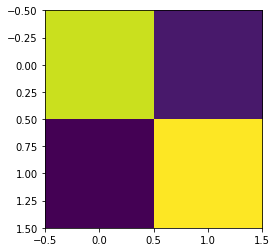

In [30]:
# select score for best C
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix


Cs = np.logspace(-4, 4, 3)

#  Note the grid has cross-validation results stored in .cv_results_['mean_test_score']
mean_scores = np.array(grid.cv_results_['mean_test_score'])
print(mean_scores)

# scores are in the order of param_grid iteration, which is alphabetical
#mean_scores = mean_scores.reshape(len(Cs), -1, len(n_components))
#print(mean_scores)


mean_scores = mean_scores.max(axis=0)
print(mean_scores)

print(grid.best_params_)

#print classification report 
y_pred = grid.predict(X_test_iso)
print(classification_report(y_test_iso, y_pred))

plt.imshow(confusion_matrix(y_test_iso, y_pred))



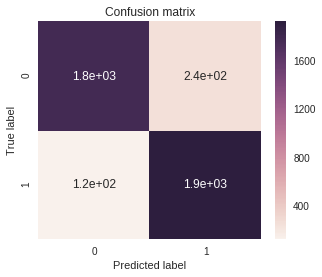

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test_iso, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

(4066,)
(4066,)
0.910567267418


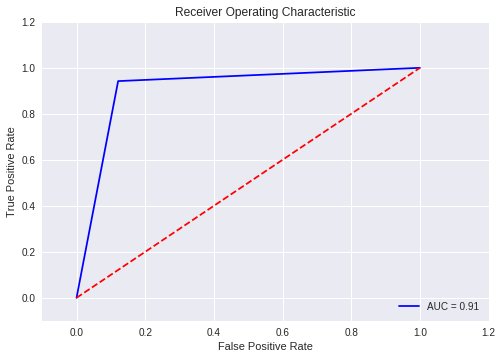

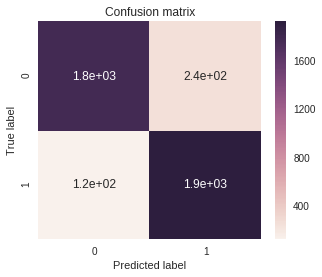

In [32]:
print(y_test_iso.shape)
print(y_pred.shape)

####ROC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_iso, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test_iso, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

###  2nd pipeline
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation

In [33]:
# STEP 1: Anomaly Detection 
from sklearn.covariance import EllipticEnvelope

# Fit envelope
envelope = EllipticEnvelope(support_fraction=1, contamination=0.2).fit(X, y)

# Create an boolean indexing array to pick up outliers
outliers = envelope.predict(X)==-1

# Re-slice X,y into a cleaned dataset with outliers excluded
X_clean = X[~outliers]
y_clean = y[~outliers]

# Train-test split
X_train_env, X_test_env, y_train_env, y_test_env = train_test_split(X_clean, y_clean, test_size=0.2)

In [34]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()
pca = decomposition.PCA()
top_feat = feature_selection.SelectKBest()


pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Prediction
n_components = [4, 8, 16]
K = [3, 5, 10, 15, 20]
Cs = np.logspace(-4, 4, 3)

param_grid = [
    {
#        'feat__k': K,
        'pca': n_components, 
        'logistic__C' : Cs
    },
]



# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, logistic__C=Cs), cv=5)
# estimator = GridSearchCV(pipe, param_grid = param_grid, cv=5)


estimator.fit(X_train_env, y_train_env)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [4, 8, 16], 'logistic__C': array([  1.00000e-04,   1.00000e+00,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

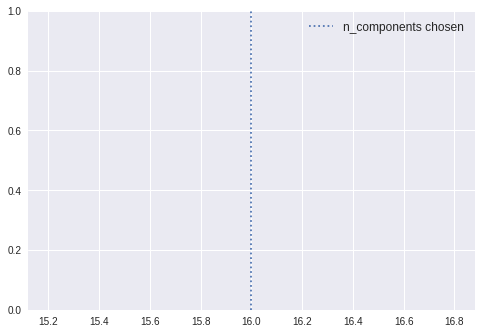

In [35]:
# make a plot to view the number of components chosen 
plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [38]:
# view parameters by commenting out code below
# grid_scores = estimator.grid_scores_
# grid_scores

In [39]:
print(estimator.best_params_)

#X.columns[features.get_support()]
print(estimator.best_estimator_) 

{'pca__n_components': 16, 'logistic__C': 10000.0}
Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


[ 0.69705984  0.72459357  0.72653061  0.78395019  0.80456589  0.81217572
  0.78395019  0.80449671  0.81231408]
[[[ 0.69705984  0.72459357  0.72653061]]

 [[ 0.78395019  0.80456589  0.81217572]]

 [[ 0.78395019  0.80449671  0.81231408]]]
[[ 0.78395019  0.80456589  0.81231408]]
{'pca__n_components': 16, 'logistic__C': 10000.0}
             precision    recall  f1-score   support

        0.0       0.87      0.74      0.80      1758
        1.0       0.78      0.89      0.83      1856

avg / total       0.82      0.82      0.82      3614

0.818760376314
0.816697253442


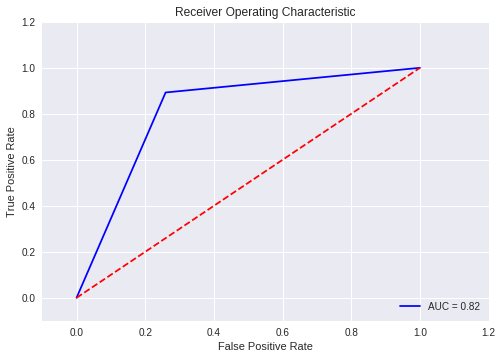

In [40]:
# select score for best C
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score


#  Note the grid has cross-validation results stored in .cv_results_['mean_test_score']
mean_scores = np.array(estimator.cv_results_['mean_test_score'])
print(mean_scores)

# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(Cs), -1, len(n_components))
print(mean_scores)

mean_scores = mean_scores.max(axis=0)
print(mean_scores)

print(estimator.best_params_)

#print classification report 
y_pred = estimator.predict(X_test_env)
print(classification_report(y_test_env, y_pred))

print(accuracy_score(y_test_env, y_pred))

####ROC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_env, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




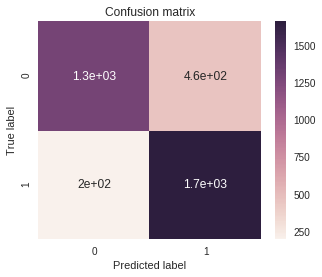

In [41]:
#####confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test_env, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

###  3rd pipeline
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation

In [42]:
# STEP 1: Anomaly Detection 
from sklearn.covariance import EllipticEnvelope

# Fit envelope
envelope = EllipticEnvelope(support_fraction=1, contamination=0.2).fit(X, y)

# Create an boolean indexing array to pick up outliers
outliers = envelope.predict(X)==-1

# Re-slice X,y into a cleaned dataset with outliers excluded
X_clean = X[~outliers]
y_clean = y[~outliers]

# Train-test split
X_train_env, X_test_env, y_train_env, y_test_env = train_test_split(X_clean, y_clean, test_size=0.2)

In [43]:
# add some more libraries 
from __future__ import print_function, division
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import scale
from sklearn import linear_model, decomposition, datasets
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

fa = FactorAnalysis()
top_feat = feature_selection.SelectKBest()

pipe = Pipeline(steps=[('scaler', StandardScaler()), ('feat', top_feat), ('classify', LinearSVC())])

K = [3, 5, 8, 10, 15, 20]
C_OPTIONS = [0.001, 0.1, 10, 100]
param_grid = [
    {'feat__k': K,
     'classify__C': C_OPTIONS
    }] 

grid = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=param_grid)

grid.fit(X_train_env, y_train_env)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feat', SelectKBest(k=10, score_func=<function f_classif at 0x7ffb759f36a8>)), ('classify', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'feat__k': [3, 5, 8, 10, 15, 20], 'classify__C': [0.001, 0.1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [44]:
#grid_scores = grid.grid_scores_

#grid_scores

[ 0.74569353  0.74949844  0.76603251  0.77820823  0.78623314  0.78768592
  0.76063646  0.76298859  0.78422691  0.79993082  0.81086129  0.81099965
  0.7604981   0.77281218  0.79072985  0.80484262  0.81757177  0.81971636
  0.77924594  0.76340367  0.73766863  0.74991352  0.73870633  0.74251124]
0.819716361121
{'feat__k': 20, 'classify__C': 10}
             precision    recall  f1-score   support

        0.0       0.86      0.78      0.82      1758
        1.0       0.81      0.88      0.84      1856

avg / total       0.83      0.83      0.83      3614

0.828168234643
0.8268629124


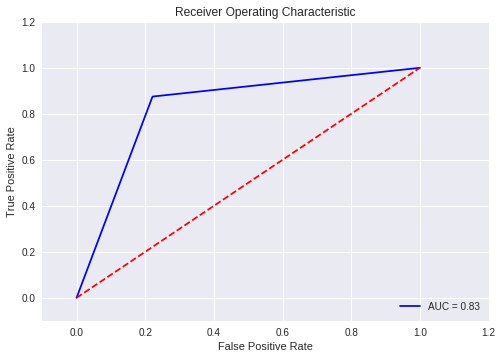

In [54]:
# select score for best C
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score


#  Note the grid has cross-validation results stored in .cv_results_['mean_test_score']
mean_scores = np.array(grid.cv_results_['mean_test_score'])
print(mean_scores)

# scores are in the order of param_grid iteration, which is alphabetical
#mean_scores = mean_scores.reshape(len(Cs), -1, len(n_components))
#print(mean_scores)

mean_scores = mean_scores.max(axis=0)
print(mean_scores)

print(grid.best_params_)

#print classification report 
y_pred = grid.predict(X_test_env)
print(classification_report(y_test_env, y_pred))

print(accuracy_score(y_test_env, y_pred))

####ROC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_env, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




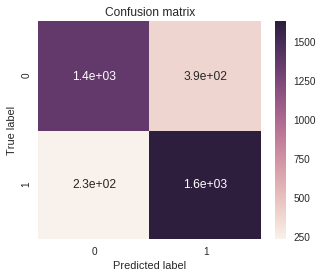

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test_env, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Document the cross-validation analysis for the three models



# Now Let's retrain a model using the full data set

Use the training data set to train the model.

In [131]:
# STEP 1: Anomaly Detection 
from sklearn.covariance import EllipticEnvelope

# Fit envelope
envelope = EllipticEnvelope(support_fraction=1, contamination=0.2).fit(X, y)

# Create an boolean indexing array to pick up outliers
outliers = envelope.predict(X)==-1

# Re-slice X,y into a cleaned dataset with outliers excluded
X_clean = X[~outliers]
y_clean = y[~outliers]

# Train-test split
X_train_env, X_test_env, y_train_env, y_test_env = train_test_split(X_clean, y_clean, test_size=0.2)

lin_clf = LinearSVC(C=10, random_state=0)
lin_clf.fit(X, y)


#{'feat__k': 20, 'classify__C': 10}

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

### Save the trained model with the pickle library.

In [132]:
# note to self - edit the code below to fit your work above
from sklearn.externals import joblib
joblib.dump(lin_clf, 'classifier.pkl')


['classifier.pkl']

### Reload the trained model from the pickle file


In [133]:
from sklearn.externals import joblib

# load pickled model
ClassiferModel = joblib.load('classifier.pkl')

## Test
Test the model using the testing data set.
 * `/dsa/data/all_datasets/back_order/Kaggle_Test_Dataset_v2.csv`

Input vs. output shape:
(3614, 20) (3614,)
             precision    recall  f1-score   support

        0.0       0.92      0.62      0.74      1759
        1.0       0.72      0.95      0.82      1855

avg / total       0.82      0.79      0.78      3614

accuracy score:  0.787216380742
0.782763270604


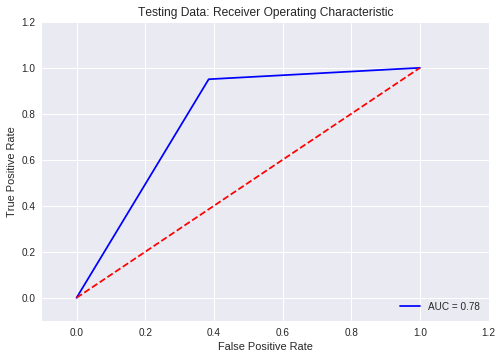

[[1082  677]
 [  92 1763]]


In [134]:
from sklearn.metrics import accuracy_score, confusion_matrix

# make predictions with test data 
y_pred = ClassiferModel.predict(X_test_env)

# verify input and output shape are appropriate
print("Input vs. output shape:")
print(X_test_env.shape, y_pred.shape)

#print classification report 
print(classification_report(y_test_env, y_pred))

print("accuracy score: ", accuracy_score(y_test_env, y_pred))

####ROC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_env, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

plt.title('Testing Data: Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# show confusion matrix in the raw 
print(confusion_matrix(y_test_env, y_pred))

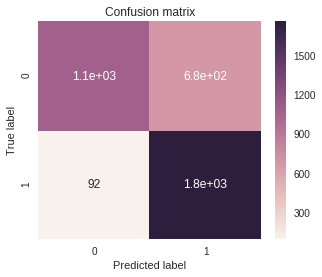

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test_env, y_pred)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')



## Conclusion

# Summary of analysis 


I believe the linear SVM model is one of the best options for predicting backorders on the dataset.  It performs pretty well with a limited amount of processing.  In terms of the data processing, I used three main approachs.  I filled the lead time column with the mean avgs and scaled this variable.  Scaling a time variable makes more sense to me than other variables as time can have a clear min/max range.  When I trained the model, I also downsampled so I was working with a balanced data set that had backorders and didn't.  I then seperated outliers in the data using Elliptic Envelope.  Both these approaches left me with only about ~16,000 records to train my model on.  (note we started with about 1.6 million records so that's quite a large reduction).  

When testing the data, I filled the missing values in the lead time variable with the mean and scaled this column.  I also dropped a few of the rows with NA values.  There were only a few of these rows dropped.  


I ended up with reasonable results.  My model score on the testing data was about ~78%. The model still has a fair amount of false positives - so in reality this would translate to predicting a backorder when none exists.  One of the reasons I liked the model best was that it was able to predict the back order class more often than other models.  Here we see the percision for class 1.0 is around 72 percent.  In terms of implementing this model one might need to consider if that is an acceptible rate of fale positives and probably have a human somewhat involved to supervise these decisions.  I'm sure there is a better approach, but this is where I'm leaving thing.  As a next steps we'd want to test on more data the model hasn't seen.  

             precision    recall  f1-score   support

        0.0       0.92      0.62      0.74      1759
        1.0       0.72      0.95      0.82      1855

avg / total       0.82      0.79      0.78      3614
